In [26]:
!pip install pillow-simd
!pip install --upgrade tables

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
from PIL import Image
from google.colab import files
from io import BytesIO
import numpy as np
from time import time
from numba import cuda

In [28]:
uploaded = files.upload()

Saving cowboy_bebop.jpg to cowboy_bebop (1).jpg


In [29]:
img = Image.open(BytesIO(uploaded['cowboy_bebop.jpg']))

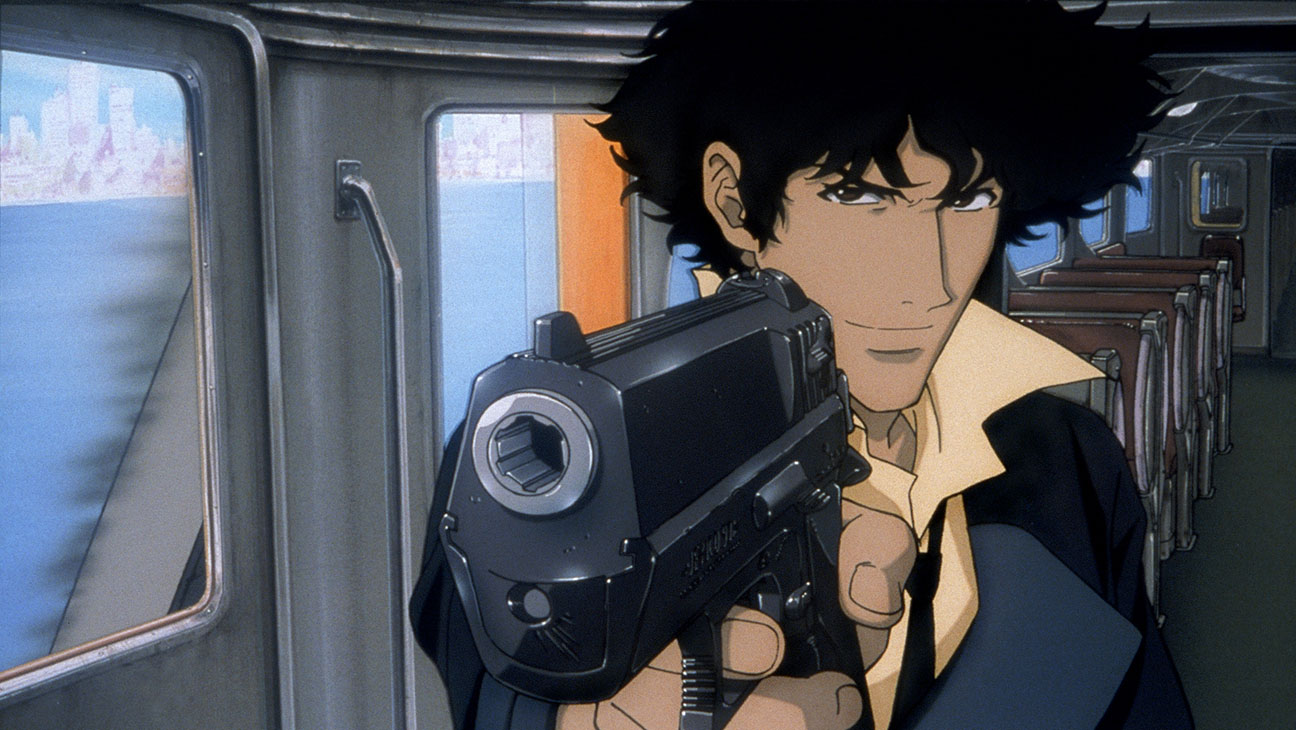

In [30]:
img

In [31]:
#реализация алгоритма на CPU
def cpu_interp(img_list):
  for i in range(len(img_list)):
    for j in range(0, len(img_list[i])*2, 2):
      img_list[i].insert(j, img_list[i][j])
  for i in range(0, len(img_list)*2, 2):
    img_list.insert(i, img_list[i])

In [32]:
#реализация алгоритма на GPU
@cuda.jit
def gpu_interp(array, result):
  i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
  cuda.syncthreads()
  if i < result.shape[0]:
    for j in range(result.shape[1]):
      for k in range(3):
        result[i*2][j*2][k] = array[i][j][k]
        result[i*2][j*2+1][k] = array[i][j][k]

        result[i*2+1][j*2][k] = array[i][j][k]
        result[i*2+1][j*2+1][k] = array[i][j][k]

In [33]:
img_arr = np.asarray(img) #конвертация изображения в массив
img_list = img_arr.tolist() #конвертация в лист

size=len(img_list)#переменная для конфигурации количества нитей и блоков

print(len(img_list))
print(len(img_list[0]))

730
1296


Тестирование на CPU

In [41]:
cpu_time_results=np.zeros(10)

for i in range(len(cpu_time_results)):

  img_arr = np.asarray(img)
  img_list = img_arr.tolist()

  start_cpu = time()
  cpu_interp(img_list)
  result_time_cpu = time() - start_cpu
  cpu_time_results[i]=result_time_cpu

avg_time_result_cpu=np.mean(cpu_time_results)
print("Среднее время выполнения функции на CPU: ", avg_time_result_cpu)

Среднее время выполнения функции на CPU:  0.41200871467590333


In [35]:
print(len(img_list))
print(len(img_list[0]))

1460
2592


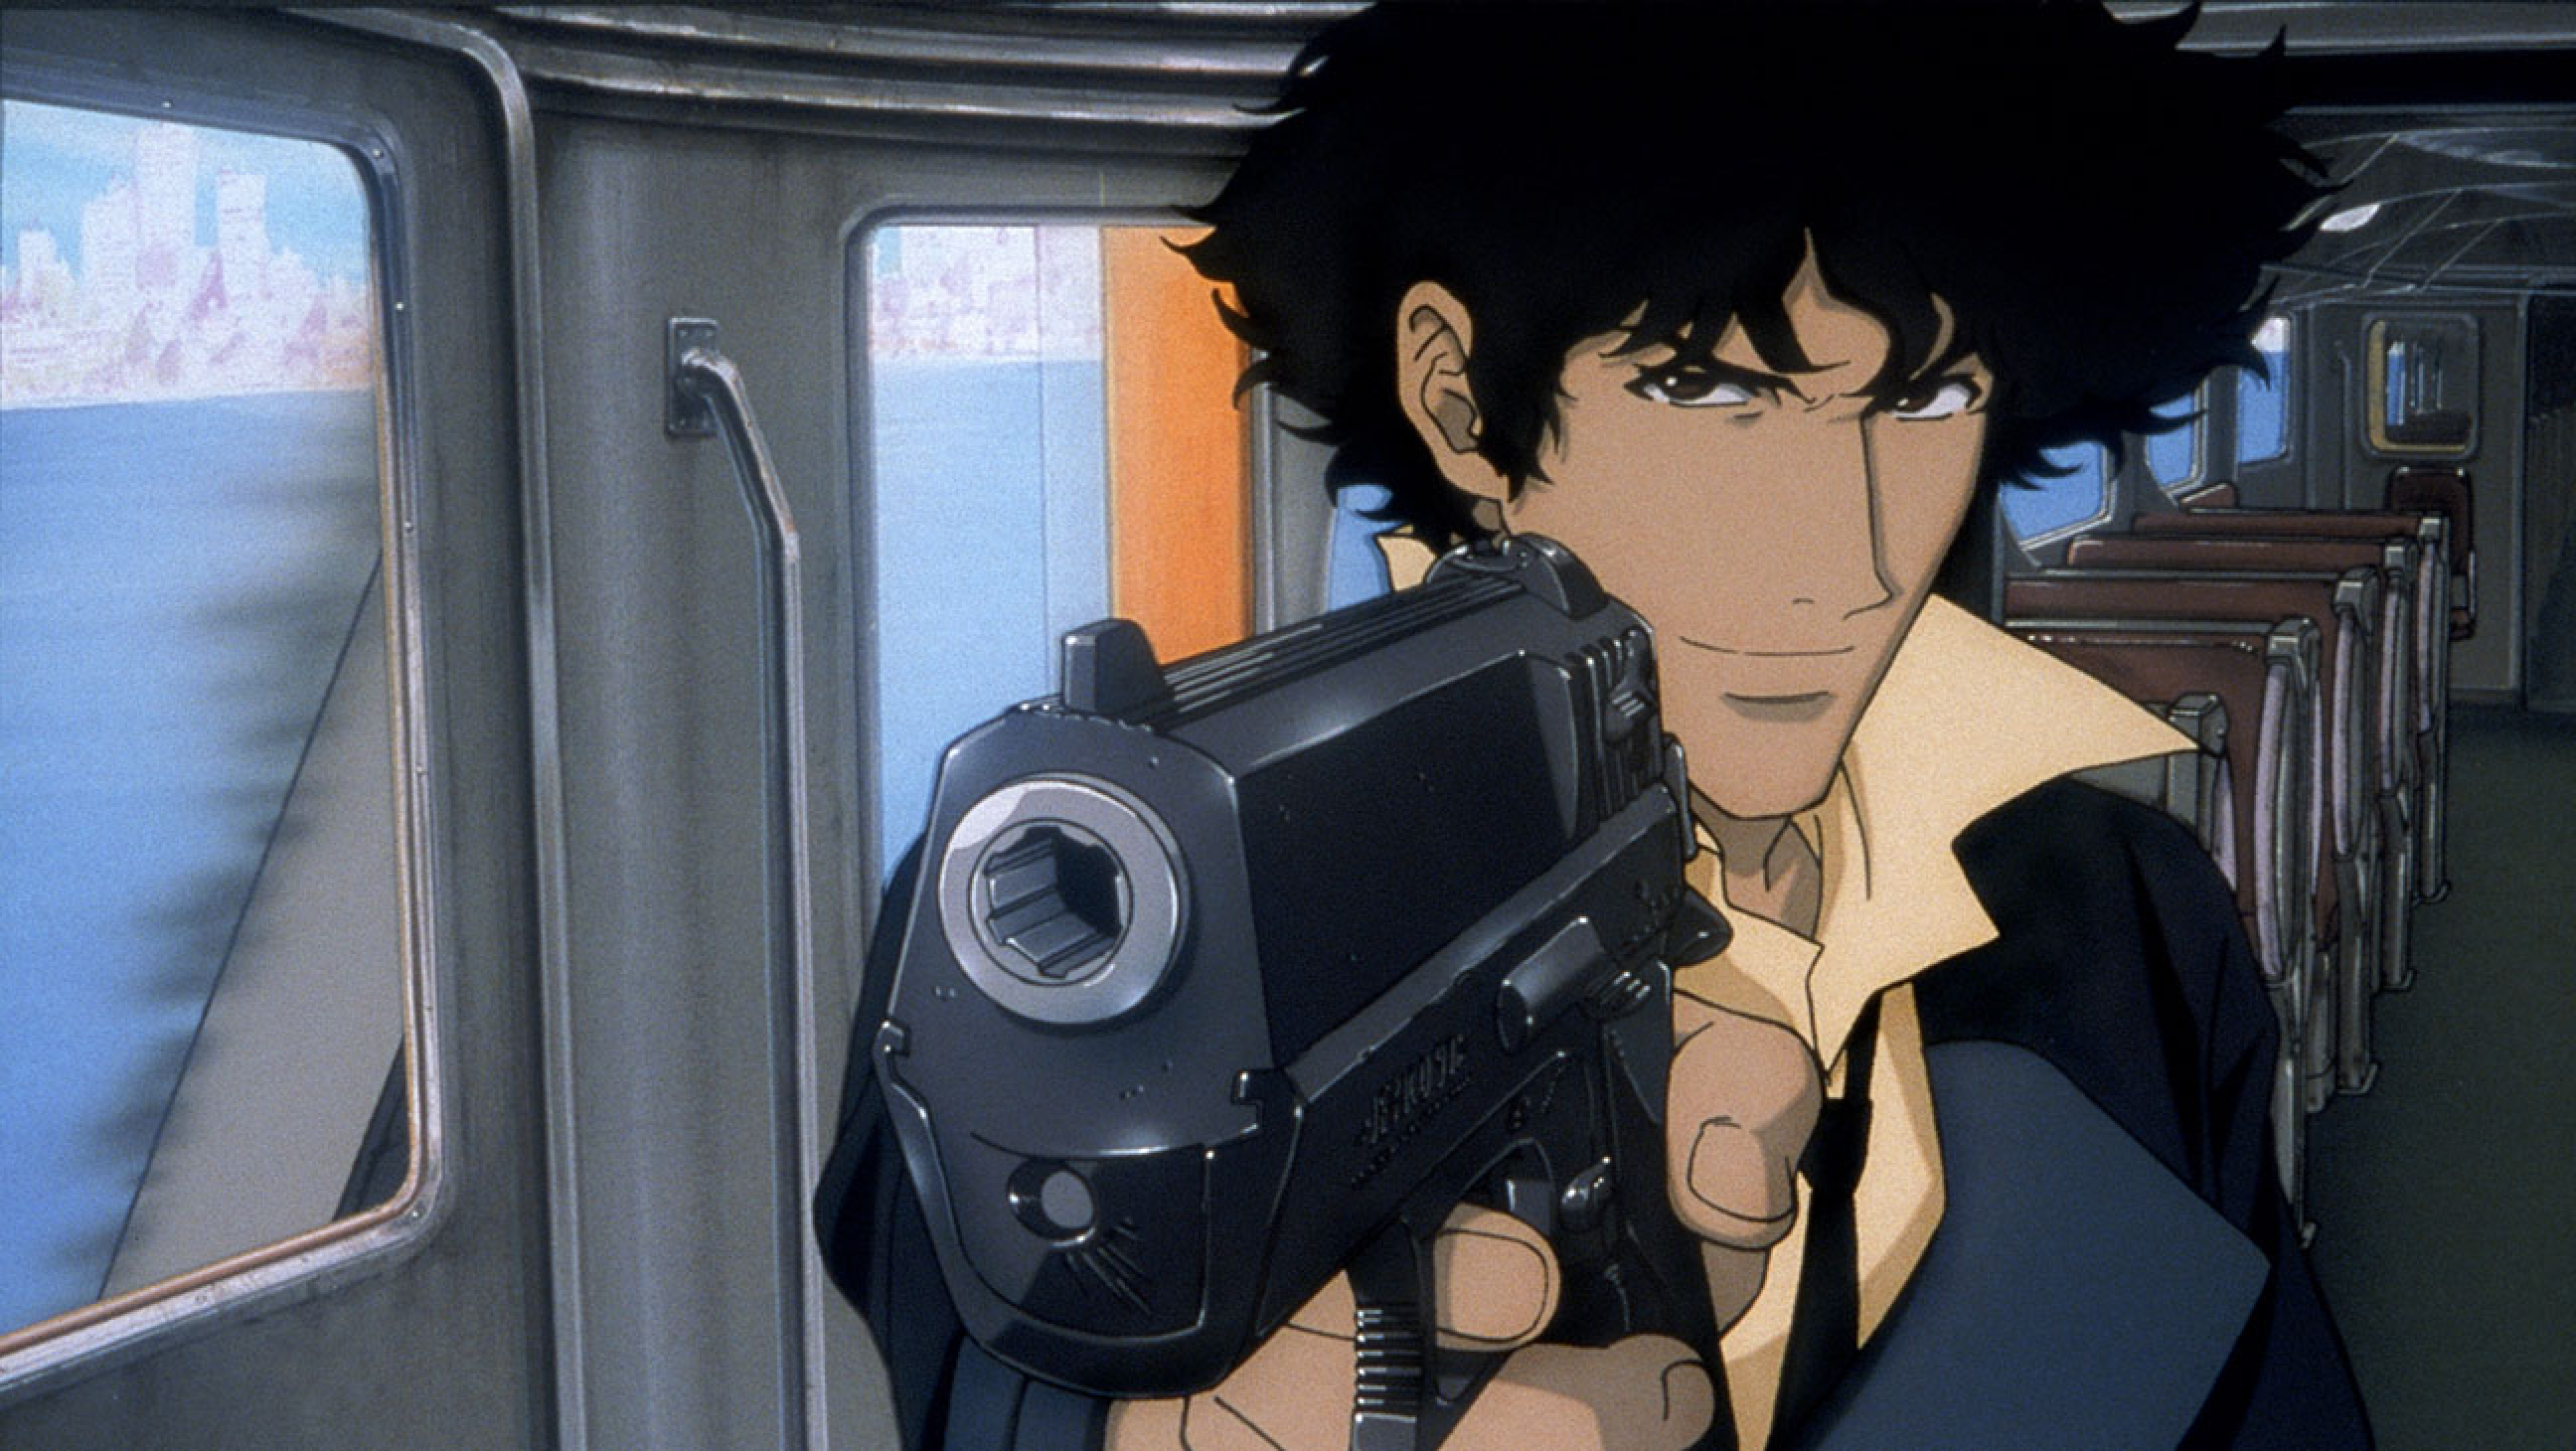

In [36]:
img_list_new = np.array(img_list)
img_list_new = img_list_new.astype(np.uint8)
img_list_new = Image.fromarray(img_list_new, 'RGB')
img_list_new

Тестирование на GPU

In [44]:
threads_per_block = 32
blocks_per_grid = size//32+1

In [48]:
gpu_time_results=np.zeros(10)

for i in range(10):
  img_arr_gpu = np.asarray(img)
  img_list_gpu = img_arr_gpu.tolist()

  h0 = len(img_list_gpu)*2
  h1 = len(img_list_gpu[0])*2
  h2 = len(img_list_gpu[0][0])

  arr_zer = np.ones([h0, h1, h2], dtype=int)

  start_gpu = time()
  gpu_interp[blocks_per_grid, threads_per_block](img_arr_gpu, arr_zer)
  result_time_gpu = time() - start_gpu
  gpu_time_results[i]=result_time_gpu

avg_time_result_gpu=np.mean(gpu_time_results)
print("Среднее время выполнения функции на CPU: ", avg_time_result_gpu)

Среднее время выполнения функции на CPU:  0.05081264972686768


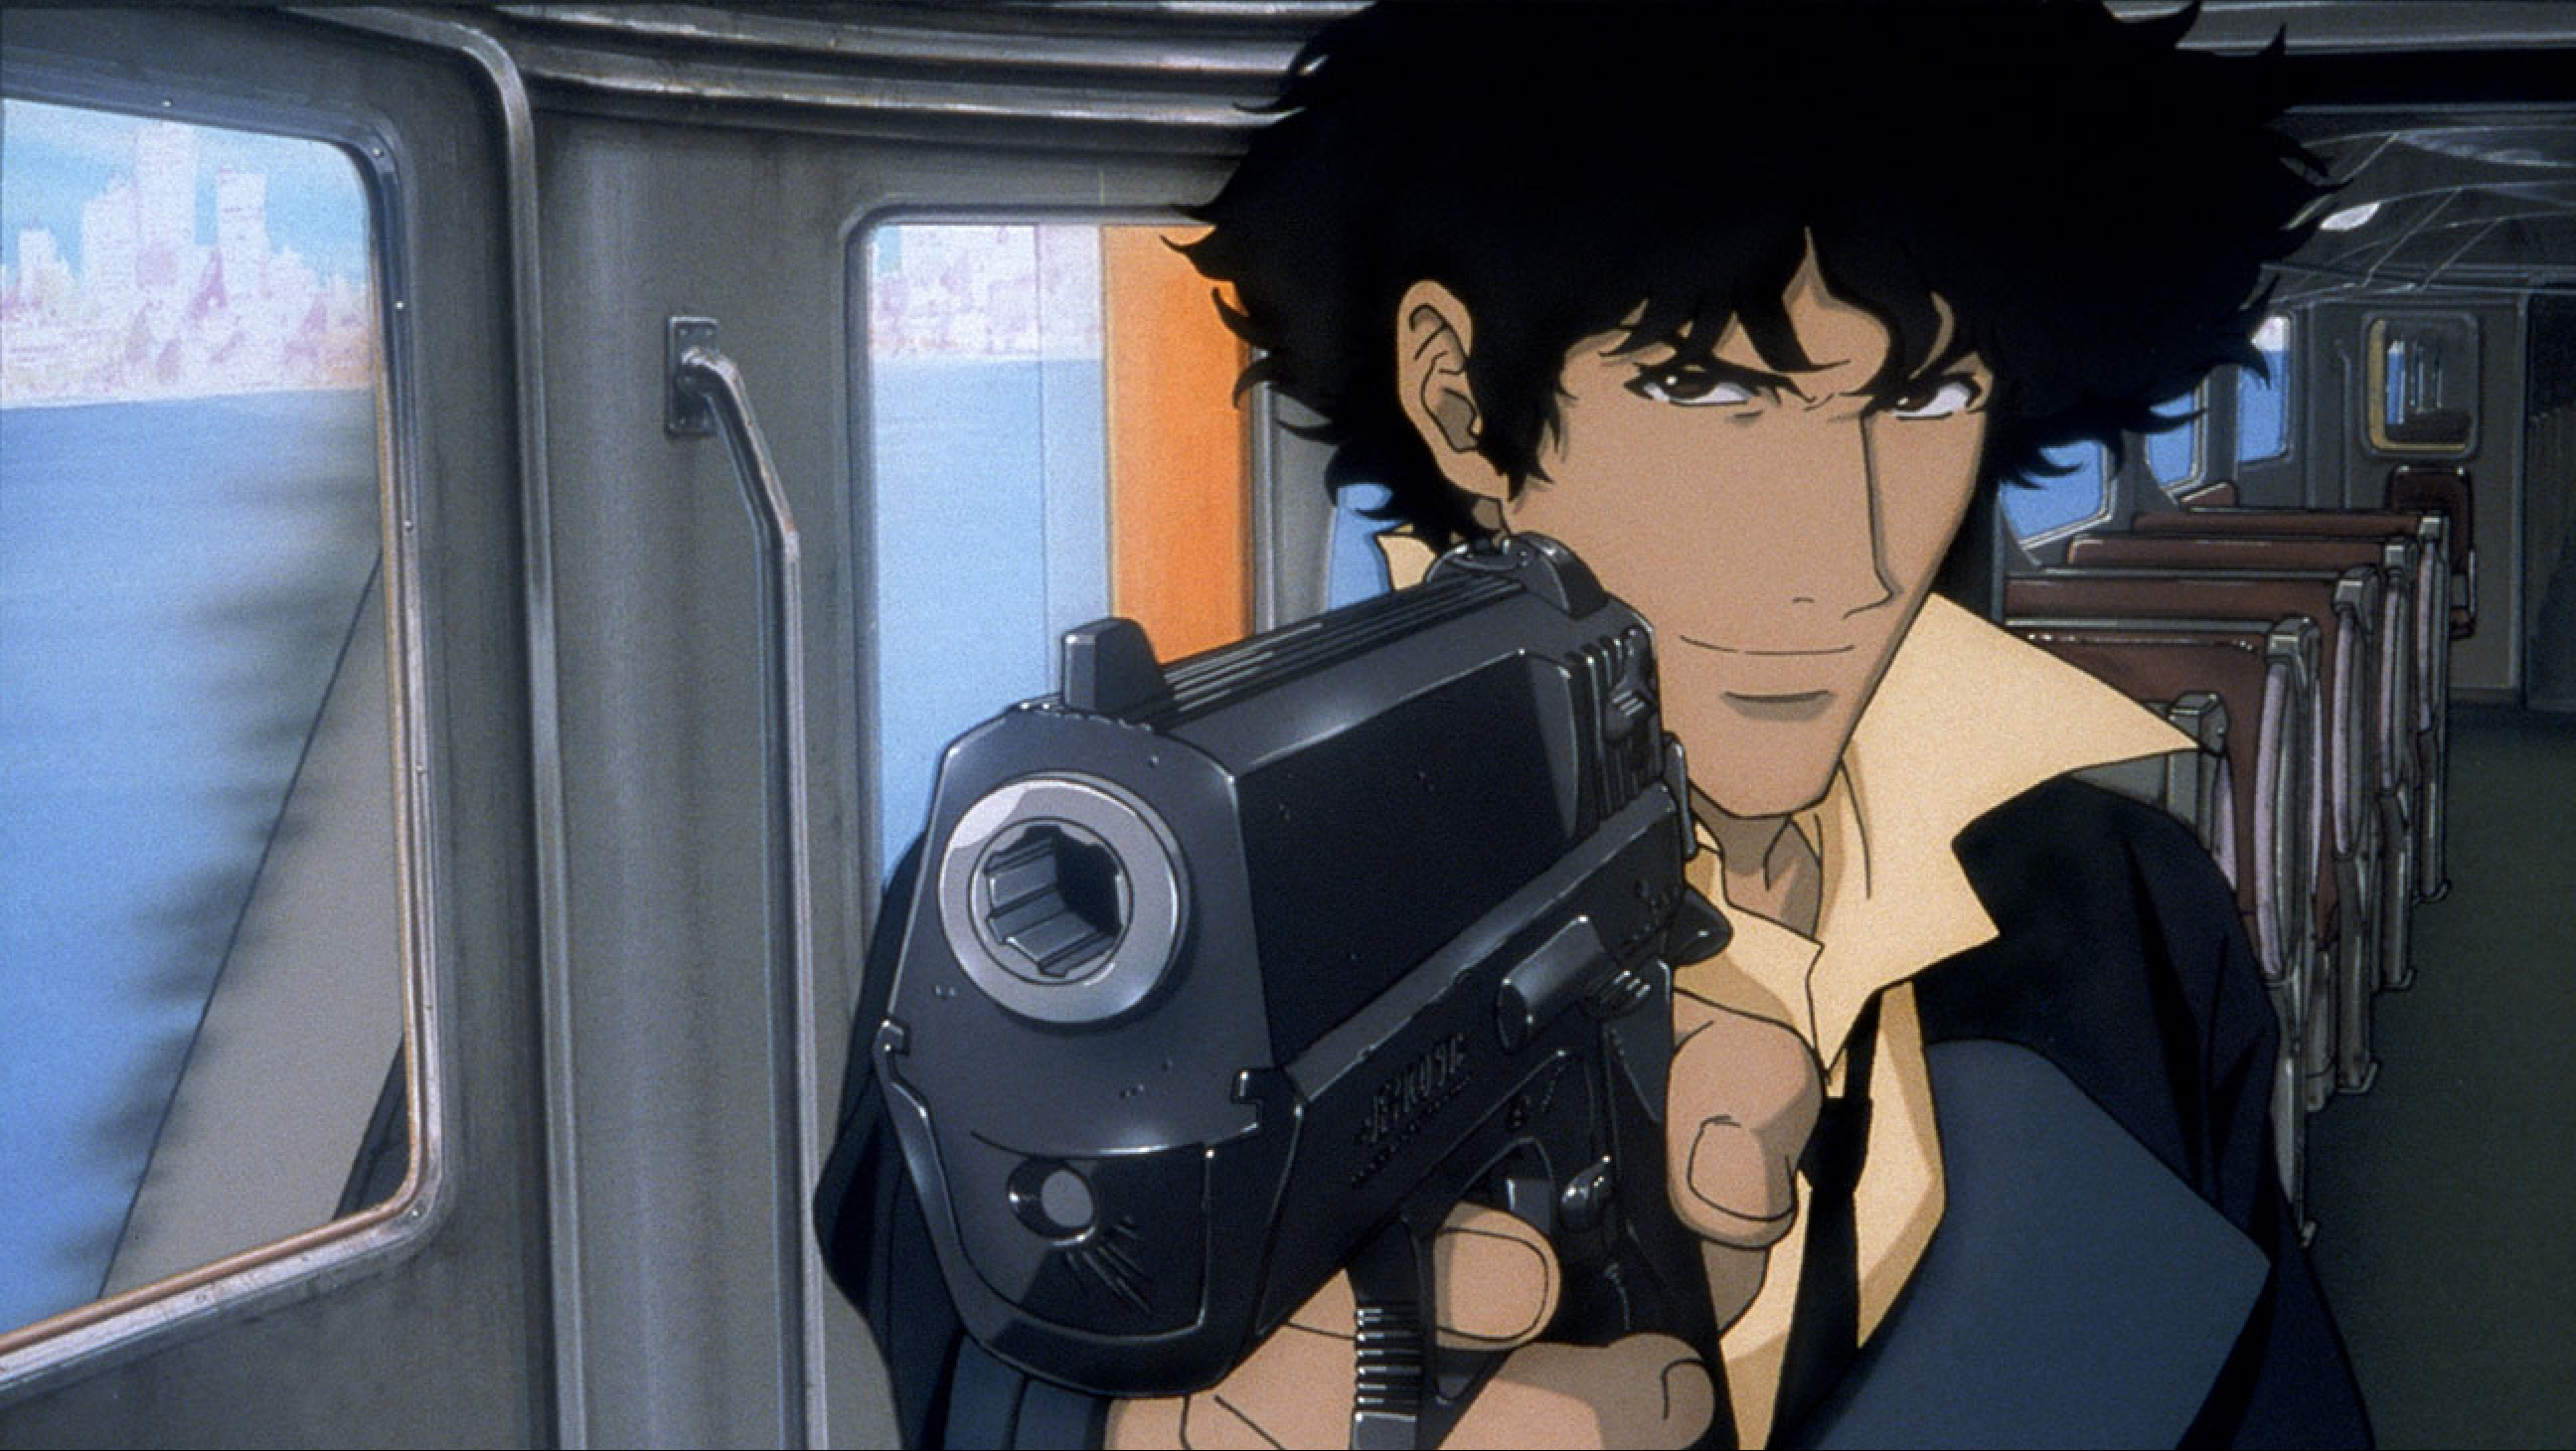

In [46]:
arr_zer = arr_zer.astype(np.uint8)
gpu_img = Image.fromarray(arr_zer, 'RGB')
gpu_img

In [47]:
print("Выполнение алгоритма на CPU затратило времени больше чем на GPU примерно в %d раз" % (avg_time_result_cpu/avg_time_result_gpu) )

Выполнение алгоритма на CPU затратило времени больше чем на GPU примерно в 8 раз
